In [1]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage import transform  
import shutil
import math
from sympy import symbols, Eq, solve

## Position A:

Description: The occlusal plane of the impacted tooth is at the same level as the occlusal plane of the 2nd molar, or above. (The highest portion of the impacted 3rd molar is on a level with the occlusal plane, or above).

## Position B:

Description: The occlusal plane of the impacted tooth is between the occlusal plane and the cervical margin of the 2nd molar. (The highest portion of the impacted 3rd molar is below the occlusal plane but above the cervical line of the 2nd molar).

## Position C:

Description: The occlusal plane of the impacted tooth is below the cervical margin of the 2nd molar. (The highest portion of the impacted 3rd molar is below the cervical line of the 2nd molar).

In [2]:
def calculate_y(x1, y1, x2, y2, x5):
    m = (y2 - y1) / (x2 - x1)
    
    x, y = symbols('x y')
    eq1 = Eq(y - y2 - (m * x - m * x2), 0)
    eq2 = Eq(x - x5, 0)
    
    solution = solve([eq1, eq2], [x, y])
    
    x_value = solution[x]
    y_value = solution[y]
    
    y_value = round(y_value)
    
    return y_value

In [3]:
def determine_classification(x1, y1, x2, y2, x3, y3, x4, y4, x5, y5):
    # Calculate the y-coordinate where the line passing through points 1 and 2 intersects the vertical line at point 5
    y_top = calculate_y(x1, y1, x2, y2, x5)
    y_bottom = calculate_y(x3, y3, x4, y4, x5)
    
    if y5 < y_top:
        return 'A'
    elif y5 >= y_top and y5 <= y_bottom:
        return 'B'
    else:
        return 'C'

In [4]:
def load_actual_classifications(actual_file):
    """
    Load the actual classifications from the provided CSV file.

    Parameters:
        actual_file (str): Path to the CSV file containing actual classifications.

    Returns:
        dict: A dictionary mapping image names to their actual classifications.
    """
    actual_df = pd.read_csv(actual_file)
    return dict(zip(actual_df['NO'], actual_df['PG-38']))

In [5]:
def plot_images_with_coordinates_from_csv_file(csv_file, image_dir, num_images_to_plot=10):
    """
    Plots points on random images based on coordinates from a CSV file and displays them.
    Visualizes lines connecting specific landmarks for Pell and Gregory classification.

    Parameters:
        csv_file (str): Path to the CSV file containing coordinates.
        image_dir (str): Path to the folder containing images.
        num_images_to_plot (int): Number of random images to plot (default is 10).
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Randomly select num_images_to_plot rows from the DataFrame
    selected_rows = df.sample(n=num_images_to_plot)
    
    # Iterate over the selected rows
    for _, row in selected_rows.iterrows():
        # Extract the image name from the 'IMAGE' column
        image_name = row['IMAGE'] + '.png'
        image_path = os.path.join(image_dir, image_name)

        # Check if the image file exists
        if not os.path.exists(image_path):
            print(f"Error: Image file not found - {image_path}")
            continue

        # Read the image
        img = cv2.imread(image_path)

        # Check if the image is empty
        if img is None or img.size == 0:
            print(f"Error: Unable to read image - {image_path}")
            continue

        # Extract coordinates from the row
        coordinates = [(row[f'{i}-X'], row[f'{i}-Y']) for i in range(1, 6)]
        
        # Draw points on the image for each set of coordinates
        for i, (x, y) in enumerate(coordinates, 1):
            
            x, y = int(x), int(y)
            # Generate a unique color for each point
            color = (0, 255, 0)  # Green color

            # Increase the size of the dot
            cv2.circle(img, (x, y), 5, color, -1)
    
            # Label the point with a number
            cv2.putText(img, str(i), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # Draw lines and label Pell and Gregory classification
        # Assuming landmark 1, landmark 2, landmark 3, landmark 4, and landmark 5 for illustration
        x1, y1 = map(int, coordinates[0])  # Point 5
        x2, y2 = map(int, coordinates[1])  # Point 1
        x3, y3 = map(int, coordinates[2])  # Point 2
        x4, y4 = map(int, coordinates[3])  # Point 3
        x5, y5 = map(int, coordinates[4])  # Point 4

        # Draw lines connecting landmarks
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
#         cv2.line(img, (x2, y2), (x3, y3), (255, 0, 0), 2)
        cv2.line(img, (x3, y3), (x4, y4), (255, 0, 0), 2)
#         cv2.line(img, (x4, y4), (x5, y5), (255, 0, 0), 2)
    

        # Label the image based on Pell and Gregory classification
        classification_label = determine_classification(x1, y1, x2, y2, x3, y3, x4, y4, x5, y5)
        cv2.putText(img, classification_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Display the image with points and lines using matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f"Image with Points and Classification: {image_name}")
        plt.axis('off')
        plt.show()

In [6]:
def plot_images_with_coordinates(image_name, csv_file, image_dir):
    """
    Plots points on a specific image based on coordinates from a CSV file and displays them.
    Visualizes lines connecting specific landmarks for Pell and Gregory classification.

    Parameters:
        image_name (str): Name of the image file without extension.
        csv_file (str): Path to the CSV file containing coordinates.
        image_dir (str): Path to the folder containing images.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Extract the row corresponding to the provided image name
    row = df[df['IMAGE'] == image_name].iloc[0]

    # Extract the image path
    image_path = os.path.join(image_dir, f"{image_name}.png")

    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Error: Image file not found - {image_path}")
        return

    # Read the image
    img = cv2.imread(image_path)

    # Check if the image is empty
    if img is None or img.size == 0:
        print(f"Error: Unable to read image - {image_path}")
        return

    # Extract coordinates from the row
    coordinates = [(row[f'{i}-X'], row[f'{i}-Y']) for i in range(1, 6)]

    # Draw points on the image for each set of coordinates
    for i, (x, y) in enumerate(coordinates, 1):
        x, y = int(x), int(y)
        # Generate a unique color for each point
        color = (0, 255, 0)  # Green color

        # Increase the size of the dot
        cv2.circle(img, (x, y), 5, color, -1)

        # Label the point with a number
        cv2.putText(img, str(i), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Draw lines and label Pell and Gregory classification
    # Assuming landmark 1, landmark 2, landmark 3, landmark 4, and landmark 5 for illustration
    x1, y1 = map(int, coordinates[0])  # Point 5
    x2, y2 = map(int, coordinates[1])  # Point 1
    x3, y3 = map(int, coordinates[2])  # Point 2
    x4, y4 = map(int, coordinates[3])  # Point 3
    x5, y5 = map(int, coordinates[4])  # Point 4

    # Draw lines connecting landmarks
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.line(img, (x2, y2), (x3, y3), (255, 0, 0), 2)
    cv2.line(img, (x3, y3), (x4, y4), (255, 0, 0), 2)
    cv2.line(img, (x4, y4), (x5, y5), (255, 0, 0), 2)

    # Label the image based on Pell and Gregory classification
    classification_label = determine_classification(x1, y1, x2, y2, x3, y3, x4, y4, x5, y5)
    cv2.putText(img, classification_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Display the image with points and lines using matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Image with Points and Classification: {image_name}")
    plt.axis('off')
    plt.show()

In [7]:
def plot_image_with_coordinates_from_csv(csv_file, image_dir, image_name):
    """
    Plots points on a specific image based on coordinates from a CSV file and displays them.
    Visualizes lines connecting specific landmarks for Pell and Gregory classification.

    Parameters:
        csv_file (str): Path to the CSV file containing coordinates.
        image_dir (str): Path to the folder containing images.
        image_name (str): Name of the specific image to plot.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Find the row corresponding to the specified image name
    selected_row = df[df['IMAGE'] == image_name[:-4]]

    # Check if the image file exists
    image_path = os.path.join(image_dir, image_name)
    if not os.path.exists(image_path):
        print(f"Error: Image file not found - {image_path}")
        return

    # Read the image
    img = cv2.imread(image_path)

    # Check if the image is empty
    if img is None or img.size == 0:
        print(f"Error: Unable to read image - {image_path}")
        return

    # Extract coordinates from the row
    coordinates = [(selected_row[f'{i}-X'].values[0], selected_row[f'{i}-Y'].values[0]) for i in range(1, 6)]

    # Draw points on the image for each set of coordinates
    for i, (x, y) in enumerate(coordinates, 1):
        x, y = int(x), int(y)
        # Generate a unique color for each point
        color = (0, 255, 0)  # Green color

        # Increase the size of the dot
        cv2.circle(img, (x, y), 5, color, -1)

        # Label the point with a number
        cv2.putText(img, str(i), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Draw lines and label Pell and Gregory classification
    # Assuming landmark 1, landmark 2, landmark 3, landmark 4, and landmark 5 for illustration
    x1, y1 = map(int, coordinates[0])  # Point 5
    x2, y2 = map(int, coordinates[1])  # Point 1
    x3, y3 = map(int, coordinates[2])  # Point 2
    x4, y4 = map(int, coordinates[3])  # Point 3
    x5, y5 = map(int, coordinates[4])  # Point 4

     # Calculate y_top and y_bottom using the provided function calculate_y
    y_top = int(calculate_y(x1, y1, x2, y2, x5))
    y_bottom = int(calculate_y(x3, y3, x4, y4, x5))

    # Draw lines connecting landmarks
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.line(img, (x3, y3), (x4, y4), (255, 0, 0), 2)
    cv2.line(img, (x2, y2), (x5, y_top), (0, 0, 255), 2)
    cv2.line(img, (x4, y4), (x5, y_bottom), (0, 0, 255), 2)

    # Label the image based on Pell and Gregory classification
    classification_label = determine_classification(x1, y1, x2, y2, x3, y3, x4, y4, x5, y5)
    cv2.putText(img, classification_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the image with points and lines using matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Image with Points and Classification: {image_name}")
    plt.axis('off')
    plt.show()

In [8]:
predicted_file = '../data/final-data/annotations/predicted-results-37-38-PG.csv'
actual_file = '../data/final-data/annotations/37-38-PG.csv'
image_dir = '../data/final-data/resized/images/5noktapellgregory37-38' 

In [9]:
def calculate_classification_accuracy(predicted_file, actual_file):
    """
    Calculate the classification accuracy based on predicted and actual classifications.

    Parameters:
        predicted_file (str): Path to the CSV file containing predicted classifications.
        actual_file (str): Path to the CSV file containing actual classifications.

    Returns:
        float: Classification accuracy.
    """
    # Load actual classifications
    actual_classifications = load_actual_classifications(actual_file)

    # Load predicted classifications
    predicted_df = pd.read_csv(predicted_file)

    # Initialize variables for correct predictions
    correct_predictions = 0

    # Iterate over rows in the predicted DataFrame
    for _, row in predicted_df.iterrows():
        image_name = row['IMAGE']
        
        predicted_classification = determine_classification(
            row['1-X'], row['1-Y'], row['2-X'],
            row['2-Y'], row['3-X'], row['3-Y'], row['4-X'], row['4-Y'], row['5-X'], row['5-Y']
        )

        # Check if the predicted classification matches the actual classification
         # Print information for each row
        
        
        actual_classification = actual_classifications.get(image_name)
        
        print(f"Image: {image_name}.png")
        print(f"Actual Classification: {actual_classification}")
        print(f"Predicted Classification: {predicted_classification}")
        print("-" * 30)
        
        if actual_classification and predicted_classification == actual_classification:
            correct_predictions += 1
        else:
            image = image_name + '.png'
            plot_image_with_coordinates_from_csv(predicted_file, image_dir, image)
            
    # Calculate classification accuracy
    total_images = len(predicted_df)
    accuracy = correct_predictions / total_images if total_images > 0 else 0
    print(f"Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_images} correct predictions)")

    return accuracy

In [10]:
# Function to process images based on classifications in the CSV file
def process_images(coordinates_file, actual_file, image_dir):
    # Read the coordinates file into a DataFrame
    predicted_df = pd.read_csv(coordinates_file)

    # Read the actual classifications file into a dictionary
    actual_classifications = pd.read_csv(actual_file, index_col='NO')['PG-38'].to_dict()

    # Initialize variables for correct and wrong predictions
    correct_predictions = 0
    wrong_predictions = 0

    # Iterate over rows in the DataFrame
    for _, row in predicted_df.iterrows():
        # Extract image name and coordinates
        image_name = row['IMAGE']
        coordinates = [(row[f'{i}-X'], row[f'{i}-Y']) for i in range(1, 6)]

        # Determine classification based on coordinates
        predicted_classification = determine_classification(*sum(coordinates, ()))

        # Compare with actual classification
        actual_classification = actual_classifications.get(image_name, 'N/A')
        
        # Print information for each row
        print(f"Image: {image_name}.png")
        print(f"Expert Classification: {actual_classification}")
        print(f"Predicted Classification: {predicted_classification}")
        print("-" * 30)

        # Check if the predicted classification matches the actual classification
        if actual_classification != 'N/A' and predicted_classification == actual_classification:
            correct_predictions += 1
        else:
            image = image_name + '.tif'
            plot_image_with_coordinates_from_csv(coordinates_file, image_dir, image)
            wrong_predictions += 1

    # Calculate classification accuracy
    total_images = len(predicted_df)
    accuracy = correct_predictions / total_images if total_images > 0 else 0
    print(f"Accuracy 37-38-PG: {accuracy:.2f}% ({correct_predictions}/{total_images} correct predictions, {wrong_predictions} wrong predictions)")

Image: 1-e-27.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 8-e-31.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 11-e-29.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 15-e-22.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 21-k-25.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 22-e-33.png
Expert Classification: A
Predicted Classification: B
------------------------------


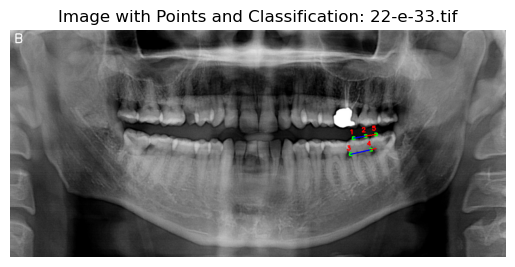

Image: 24-e-21.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 27-k-33.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 28-k-22.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 29-e-22.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 30-31-52.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 30-e-28.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 51-1094-k.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 52-1095-e.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 69-1143-e.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 80-e-27.png
Expert Classification: A
Predicted Classificati

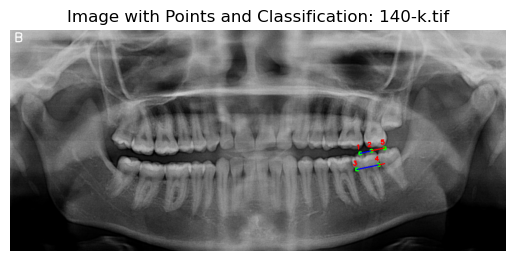

Image: 142-k.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 147-k.png
Expert Classification: C
Predicted Classification: C
------------------------------
Image: 149-e.png
Expert Classification: B
Predicted Classification: C
------------------------------


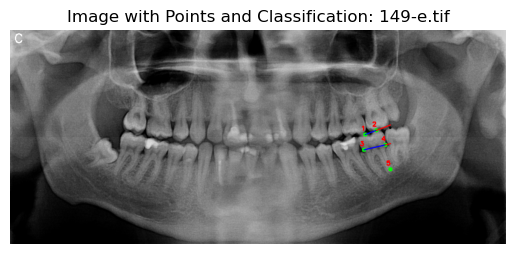

Image: 152-k.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 154-132-k.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 162-134-e.png
Expert Classification: C
Predicted Classification: C
------------------------------
Image: 165-135-k.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 170-k-23.png
Expert Classification: A
Predicted Classification: B
------------------------------


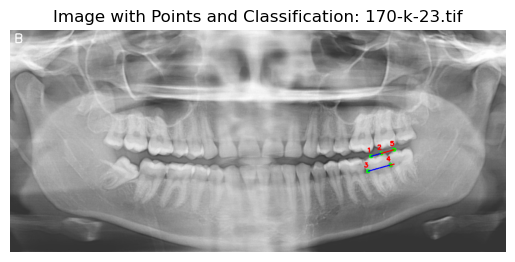

Image: 171-k-20.png
Expert Classification: A
Predicted Classification: B
------------------------------


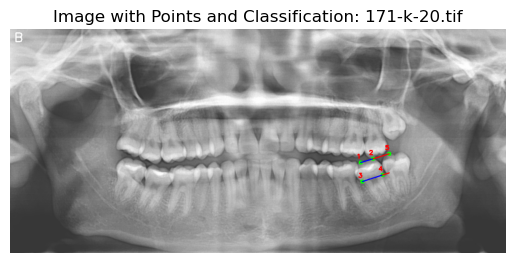

Image: 173-k-21.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 175-k-52.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 178-e-29.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 181-e-32.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 185-k-31.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 186-e-21.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 193-e-39.png
Expert Classification: A
Predicted Classification: B
------------------------------


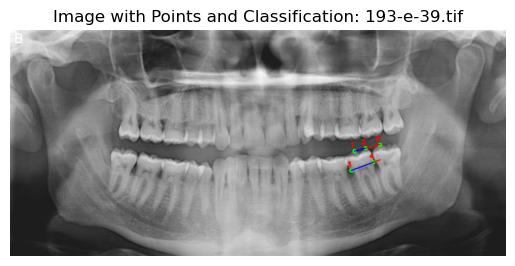

Image: 198-k-20.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 226-e-30.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 249-e-25.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 265-e-21.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 277-e-17.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 315-e-21.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 343-344.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 353-e-20.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: 354-k-18.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 357-k-20.png
Expert Classification: A
Predicted Classifica

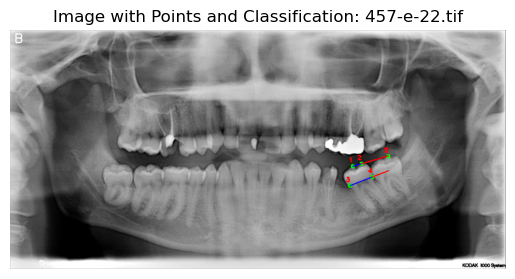

Image: 463-k-32.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 467-e-20.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 471-k-24.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 472-e-20.png
Expert Classification: A
Predicted Classification: B
------------------------------


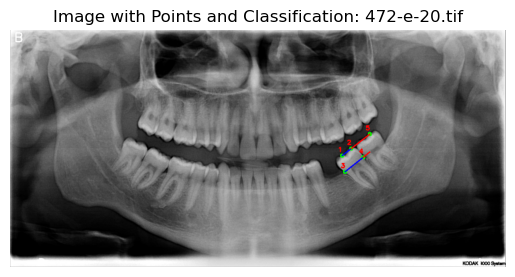

Image: 487-e-22.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 491-k-20.png
Expert Classification: B
Predicted Classification: A
------------------------------


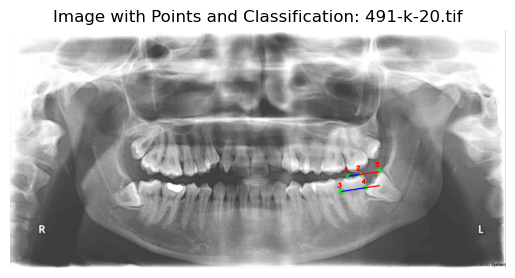

Image: 554-k-21.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 583-e-21.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 586-e-23.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 588-e-20.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 591-e-25.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 592-e-24.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 602-e-22.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 604-e-26.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 608-e-24.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: 610-e-20.png
Expert Classification: B
Predicted Classific

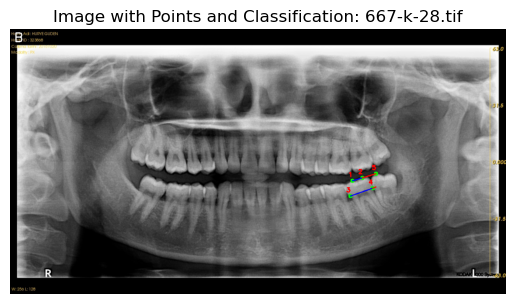

Image: 690-e-21.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-1.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-2.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-3.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-4.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-5.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-6.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-7.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-8.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-9.png
Expert Classification: A
Predicted Classification: A
------------------

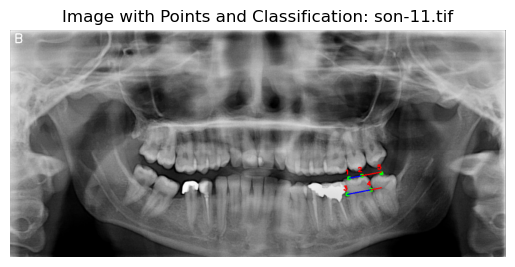

Image: son-12.png
Expert Classification: C
Predicted Classification: C
------------------------------
Image: son-13.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-14.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-15.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-16.png
Expert Classification: C
Predicted Classification: C
------------------------------
Image: son-17.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-18.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-19.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-20.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-21.png
Expert Classification: A
Predicted Classification: A
-----------

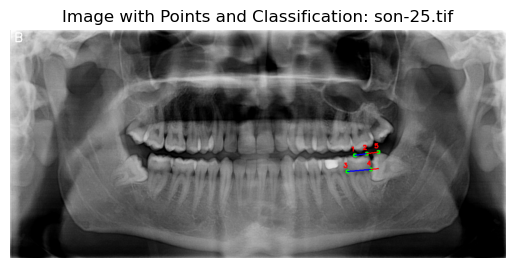

Image: son-27.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-28.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-31.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-32.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-33.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-35.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-36.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-37.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-38.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-39.png
Expert Classification: B
Predicted Classification: B
-----------

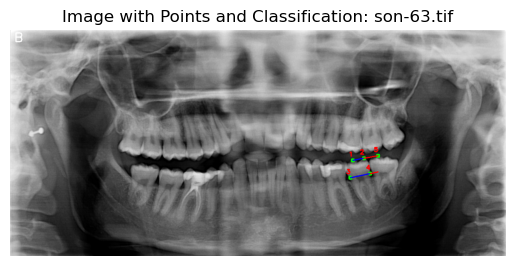

Image: son-64.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-65.png
Expert Classification: A
Predicted Classification: B
------------------------------


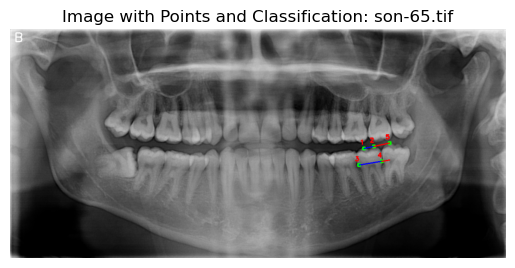

Image: son-66.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-67.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-68.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-70.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-71.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-72.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-73.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-74.png
Expert Classification: A
Predicted Classification: B
------------------------------


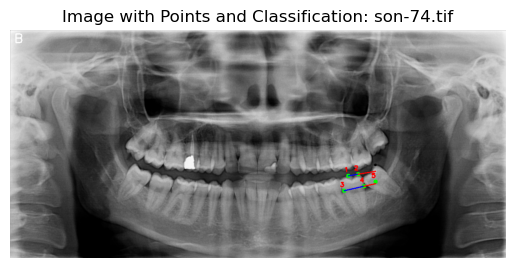

Image: son-75.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-76.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-77.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-78.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-79.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-80.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-81.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-82.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-84.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-85.png
Expert Classification: B
Predicted Classification: B
-----------

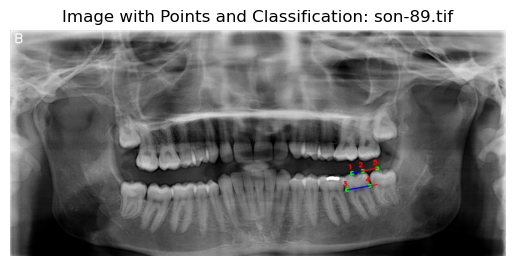

Image: son-90.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-91.png
Expert Classification: A
Predicted Classification: B
------------------------------


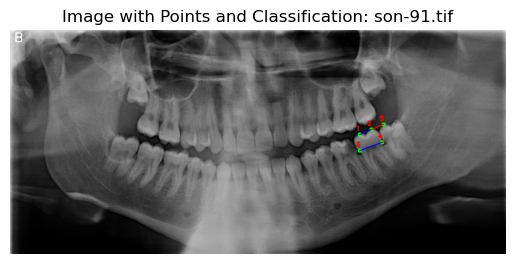

Image: son-94.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-95.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-96.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-97.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-98.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-99.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-100.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-101.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-102.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-103.png
Expert Classification: B
Predicted Classification: B
-------

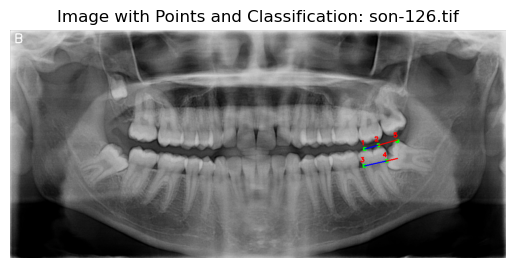

Image: son-127.png
Expert Classification: B
Predicted Classification: A
------------------------------


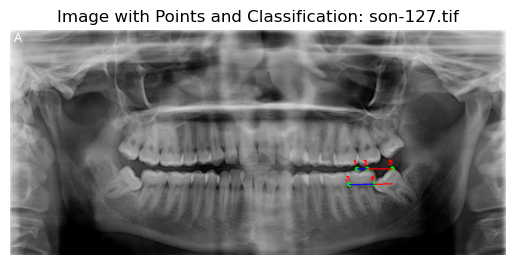

Image: son-128.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-129.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-130.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-131.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-132.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-133.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-134.png
Expert Classification: A
Predicted Classification: A
------------------------------
Image: son-135.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-137.png
Expert Classification: B
Predicted Classification: B
------------------------------
Image: son-138.png
Expert Classification: B
Predicted Classification: B
-

In [11]:
csv_file = "../data/final-data/annotations/37-38-PG.csv"
image_dir = "../data/final-data/images/5noktaPellgregory37-38-2k"
coordinates_file = "../data/final-data/annotations/37-38-PELLGREGORY-KODAK.csv"


# Call the function to process images
process_images(coordinates_file, actual_file, image_dir)